# Clustering Crypto

In [88]:
# imports
import requests
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Fetching Cryptocurrency Data

In [63]:
# Use the following endpoint to fetch json data
import json
import pprint
url = "https://min-api.cryptocompare.com/data/all/coinlist"
r = requests.get(url)
content = r.content
content_d = content.decode('utf-8')
data = json.loads(content_d)

In [64]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.
# dataframe creation
crypto_df = pd.DataFrame(data=data['Data'])

# Transpose Dataframe

crypto_df = crypto_df.transpose()
crypto_df.head(1)

,Id,Url,ImageUrl,ContentCreatedOn,Name,Symbol,CoinName,FullName,Description,AssetTokenStatus,...,BlockTime,AssetLaunchDate,MaxSupply,MktCapPenalty,PlatformType,BuiltOn,SmartContractAddress,DecimalPoints,Difficulty,IsUsedInDefi
42,4321,/coins/42/overview,/media/35650717/42.jpg,1427211129,42,42,42 Coin,42 Coin (42),Everything about 42 coin is 42 - apart from th...,N/A,...,0,0000-00-00,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
# Alternatively, use the provided csv file:
# file_path = Path("Resources/crypto_data.csv")

# Create a DataFrame
# crypto_df = pd.read_csv(file_path)
# crypto_df.head()

### Data Preprocessing

In [66]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'


# Reorder Columns that are still in the dataframe
crypto_df = crypto_df[['CoinName', 'Algorithm', 'IsTrading', 'ProofType', 'TotalCoinsMined', 'MaxSupply']]

crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,MaxSupply
42,42 Coin,Scrypt,True,PoW/PoS,0,0
300,300 token,N/A,True,N/A,300,300
365,365Coin,X11,True,PoW/PoS,0,0
404,404Coin,Scrypt,True,PoW/PoS,0,0
433,433 Token,N/A,False,N/A,NaN,NaN


In [67]:
# Keep only cryptocurrencies that are trading

# determine the count of false values(1094)
# crypto_df['IsTrading'].value_counts() 

crypto_df.drop(crypto_df[crypto_df['IsTrading'] == False].index,
              inplace=True)

In [68]:
# Keep only cryptocurrencies with a working algorithm
crypto_df.drop(crypto_df[crypto_df['Algorithm'] == 'N/A'].index, inplace=True)
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,MaxSupply
42,42 Coin,Scrypt,True,PoW/PoS,0,0
365,365Coin,X11,True,PoW/PoS,0,0
404,404Coin,Scrypt,True,PoW/PoS,0,0
611,SixEleven,SHA-256,True,PoW,0,0
808,808,SHA-256,True,PoW/PoS,0,0


In [69]:
# Remove the "IsTrading" column
crypto_df.drop(columns = ['IsTrading'], inplace=True)

In [70]:
# Remove rows with at least 1 null value
crypto_df.dropna(inplace=True)

In [71]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df.drop(crypto_df[crypto_df['TotalCoinsMined'] == 0].index, inplace=True)

In [72]:
# Drop rows where there are 'N/A' text values
crypto_df = crypto_df[crypto_df != 'N/A'].dropna()

In [73]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
CoinName_df = crypto_df['CoinName'].to_frame()


In [74]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df.drop(columns = ['CoinName'], inplace=True)

In [75]:
# Create dummy variables for text features
X = pd.get_dummies(crypto_df, columns=['Algorithm', 'ProofType'], drop_first=True)

In [76]:
# Standardize data
X_scaled = StandardScaler().fit_transform(X)

### Reducing Dimensions Using PCA

In [77]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)
crypto_pca = pca.fit_transform(X_scaled)

In [51]:
# Create a DataFrame with the principal components data
pca_df = pd.DataFrame(data=crypto_pca,
                            columns=['PC1', 'PC2', 'PC3'],
                            index=crypto_df.index
                            )
pca_df.head()

,PC1,PC2,PC3
NVC,-0.691933,0.998911,-1.585910
XCP,0.149007,-1.671488,0.128820
NSR,-0.414897,1.249935,0.764498
MONA,-0.381586,-0.968573,-0.378582
TRI,-0.759811,1.814183,-2.155481


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [18]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
# set up a FOR loopy to run thru.. 
for i in k:
    km = KMeans(n_clusters=i, random_state=6)
    km.fit(pca_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {'k': k, 'inertia': inertia}
elbow_df = pd.DataFrame(elbow_data)

elbow_df.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve Plot")

:Curve   [k]   (inertia)

Running K-Means with `k=<5>`

In [19]:
# Initialize the K-Means model
model = KMeans(n_clusters=5, random_state=0)

# Fit the model
model.fit(pca_df)

# Predict clusters
predictions = model.predict(pca_df)

# add the predicted class columns
pca_df['class'] = model.labels_
pca_df.head()

,PC1,PC2,PC3,class
NVC,-0.691933,0.998911,-1.585910,3
XCP,0.149007,-1.671488,0.128820,1
NSR,-0.414897,1.249935,0.764498,4
MONA,-0.381586,-0.968573,-0.378582,1
TRI,-0.759811,1.814183,-2.155481,3


In [20]:
# Create a new DataFrame including predicted clusters and cryptocurrencies features
clustered_df = pd.concat([crypto_df, CoinName_df, pca_df], axis=1)
clustered_df.head()

,Algorithm,ProofType,TotalCoinsMined,MaxSupply,CoinName,PC1,PC2,PC3,class
NVC,Scrypt,PoW/PoS,3.10002e+06,-1,NovaCoin,-0.691933,0.998911,-1.585910,3
XCP,SHA-256,PoW,2.6152e+06,-1,CounterParty,0.149007,-1.671488,0.128820,1
NSR,PoS,PoS,5.85104e+09,0,NuShares,-0.414897,1.249935,0.764498,4
MONA,Scrypt,PoW,8.02433e+07,-1,MonaCoin,-0.381586,-0.968573,-0.378582,1
TRI,X13,PoW/PoS,169926,0,Triangles Coin,-0.759811,1.814183,-2.155481,3


### Visualizing Results

#### 3D-Scatter with Clusters

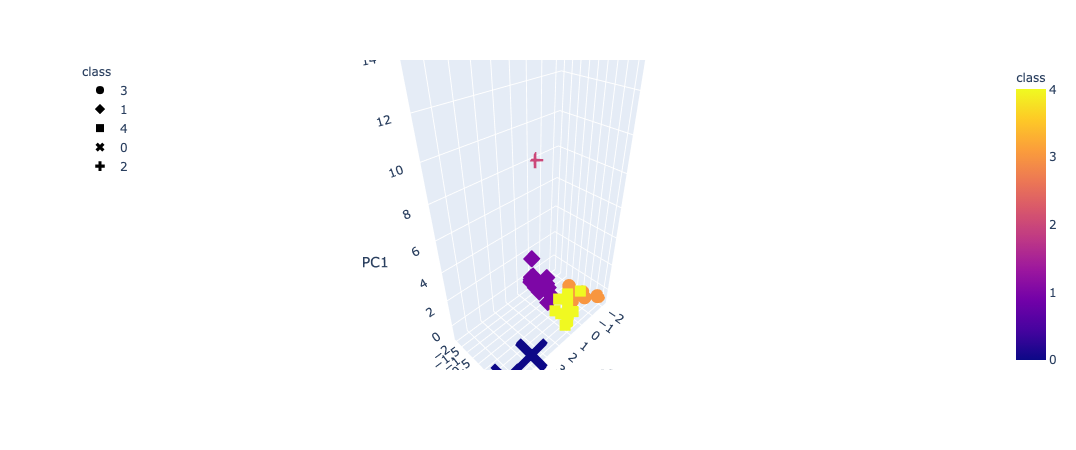

In [86]:
fig = px.scatter_3d(
    clustered_df,
    x="PC3",
    y="PC2",
    z="PC1",
    color="class",
    symbol="class",
    width=800,
    hover_name="CoinName",
    hover_data=["Algorithm"]
    
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

#### hvplot Table of Tradable Cryptocurrencies

In [129]:
# Table with tradable cryptos
clustered_df.hvplot.table(columns=['CoinName', 'Algorithm', 'ProofType', 'TotalCoinsMined', 'MaxSupply', 'class'], width=600)

:Table   [CoinName,Algorithm,ProofType,TotalCoinsMined,MaxSupply,class]

In [23]:
# Print the total number of tradable cryptocurrencies
print(f'The total number of tradable cryptocurrenices is: {len(clustered_df_no_pc)}')

The total number of tradable cryptocurrenices is: 102


#### Scatter Plot with Tradable Cryptocurrencies

In [24]:
# Scale data to create the scatter plot
scaler = MinMaxScaler()

normalize_columns = ['TotalCoinsMined', 'MaxSupply']
x = crypto_df[normalize_columns].values
x_scaled = scaler.fit_transform(x)

df_tradable = pd.DataFrame(x_scaled, columns=normalize_columns, index=crypto_df.index).reset_index()


In [130]:
# Create a scatter plot using hvplot.scatter
df_tradable.hvplot.scatter(x='TotalCoinsMined', y='MaxSupply',hover_cols=["CoinName"])

:Scatter   [TotalCoinsMined]   (MaxSupply)

In [131]:
## below is me just trying things 

# trying to get an animation for the scatter but i think the ranges are kind of messed up 
fig2 = px.scatter(df_tradable, x="TotalCoinsMined", y="MaxSupply", animation_frame="TotalCoinsMined", animation_group="MaxSupply",
                 size="MaxSupply", color="TotalCoinsMined", hover_name="TotalCoinsMined",
             log_x=True, log_y=True, size_max=45, range_x=[100,10000000], range_y=[25,140000])

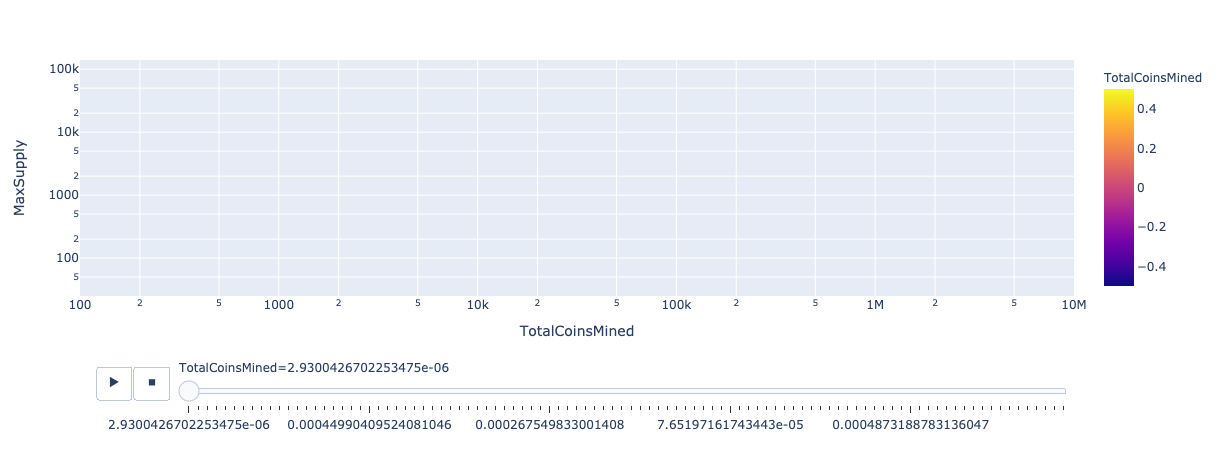

In [27]:
fig2.show()